In [52]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [53]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [54]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from datetime import datetime, timedelta


In [55]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [56]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

C:\Users\Flore\AppData\Local\Temp\ipykernel_15420\3601434573.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [57]:
# Print all of the classes mapped to the Base
print(Base.classes.keys()) 

['measurement', 'station']


In [58]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [59]:
# Create a session
session = Session(engine)


# Exploratory Precipitation Analysis

In [60]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"Most Recent Date: {most_recent_date}")

Most Recent Date: 2017-08-23


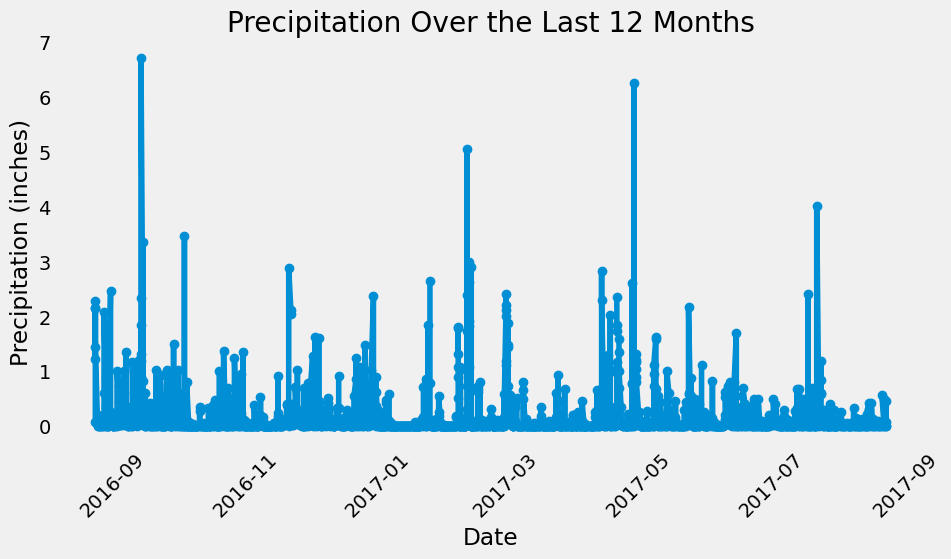

In [61]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
most_recent_date_dt = datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_ago = most_recent_date_dt - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])
df['date'] = pd.to_datetime(df['date'])

# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['precipitation'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Over the Last 12 Months')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [62]:
# Use Pandas to calculate the summary statistics for the precipitation data
df = pd.DataFrame(precipitation_data, columns=['date', 'measurment']) 
summary_stats = df['measurment'].describe()
print(summary_stats)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: measurment, dtype: float64


# Exploratory Station Analysis

In [63]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.id)).first()[0]
print(total_stations)

9


In [64]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)

active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)
# List the stations and their counts in descending order.
print(active_stations)


[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [65]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0] 

temperature_stats = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    )
    .filter(Measurement.station == most_active_station)  # Filter by the most active station
    .all()
)


print(f"Most Active Station: {most_active_station}")
print(f"Lowest Temperature: {temperature_stats[0][0]}")
print(f"Highest Temperature: {temperature_stats[0][1]}")
print(f"Average Temperature: {temperature_stats[0][2]}")



Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


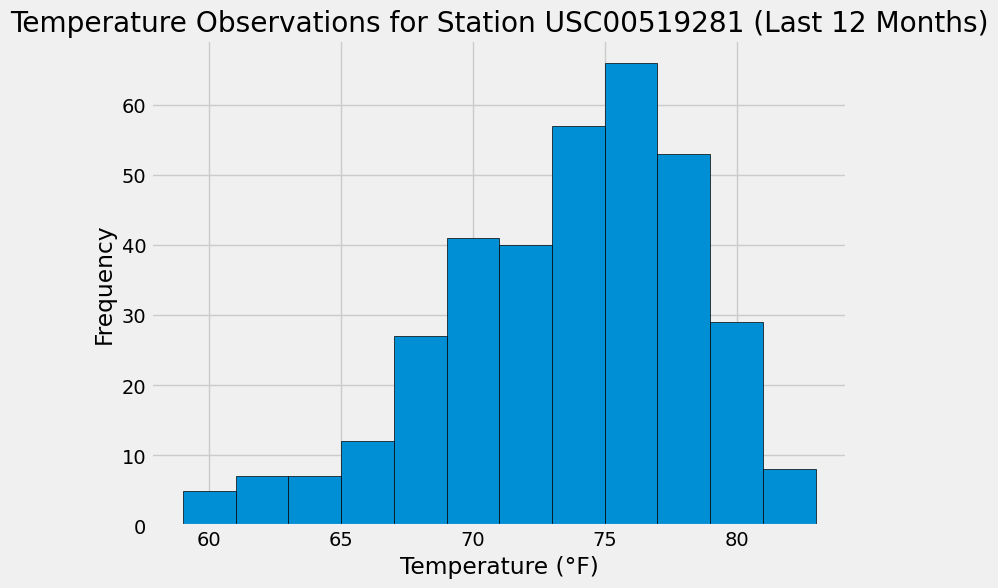

In [66]:
# Using the most active station id
one_year_ago = (pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station)  # Filter for the most active station
    .filter(Measurement.date >= one_year_ago)  # Get last 12 months of data
    .all()
)
df = pd.DataFrame(temperature_data, columns=['temperature'])

plt.figure(figsize=(8, 6))
plt.hist(df['temperature'], bins=12, edgecolor='black')
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.title(f"Temperature Observations for Station {most_active_station} (Last 12 Months)")
plt.grid(True)
plt.show()



# Close Session

In [67]:
# Close Session
session.close()
